# Analyze simulated library of codon variants
This example does the following three major things:

 1. Simulates a deep mutational scanning experiment on a "plausible" data set of barcoded codon variants.
 2. Analyze the simulated experiment by examining the variant counts and functional scores.
 3. Fits global epistasis models.

## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import itertools
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Set parameters that define the simulated data.
Except for that fact that we use a short gene to reduce the computational run-time of this notebook, these simulation parameters are designed to reflect what we might observe in a real Bloom lab deep mutational scanning experiment:

In [2]:
seed = 1  # random number seed
genelength = 30  # gene length in codons
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 200  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # random noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 100,
        }

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate wildtype gene sequence:

In [7]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 30 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTG


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function:

In [8]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

We can get basic information about the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable), such as the sites,
wildtype codons, and wildtype amino acids.
Below we do this for the first few
sites:

In [9]:
variants.sites[: 5]

[1, 2, 3, 4, 5]

In [10]:
list(variants.codons[r] for r in variants.sites[: 5])

['AGA', 'TCC', 'GTG', 'ATT', 'CTG']

In [11]:
list(variants.aas[r] for r in variants.sites[: 5])

['R', 'S', 'V', 'I', 'L']

The different libraries in the table:

In [12]:
variants.libraries

['lib_1', 'lib_2']

Here is the data frame that contains all of the information on the barcoded
variants (just looking at the first few lines)

In [13]:
variants.barcode_variant_df.head(n=6)

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,lib_1,AAAAAAAACGTTTTGT,1,CTG5TGG TCA11TCT,L5W,2,1
1,lib_1,AAAAAAAGGCTTATAC,5,TCA11TGC,S11C,1,1
2,lib_1,AAAAAAATCGTCCGTG,2,,,0,0
3,lib_1,AAAAAAGACAACACCG,5,ATC25TTC,I25F,1,1
4,lib_1,AAAAAAGATGTGGTGG,3,TCA11TTA CGG12GGT CGT15TGA ATC25GGA ATC28CGC,S11L R12G R15* I25G I28R,5,5
5,lib_1,AAAAAAGTCATACTCG,1,CGG12TCA TGC19ACC AAC27CGC,R12S C19T N27R,3,3


## Analyze library composition
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
has methods for summarizing and plotting properties of the barcoded variants.
These methods can be used to analyze the barcoded variants themselves, or to
analyze the frequency (or counts) of variants in the library in samples that
have undergone some type of selection.

We have not yet added counts of the
variants in any specific samples, so we just analyze the composition of the
variant library itself.
This is done by setting `samples=None` in the method
calls below.

Number of variants in each library:

In [14]:
variants.n_variants_df(samples=None)

,library,sample,count
0,lib_1,barcoded variants,15000
1,lib_2,barcoded variants,15000
2,all libraries,barcoded variants,30000


Plot distribution of variant call supports, grouping together all variants with support $\ge 8$:

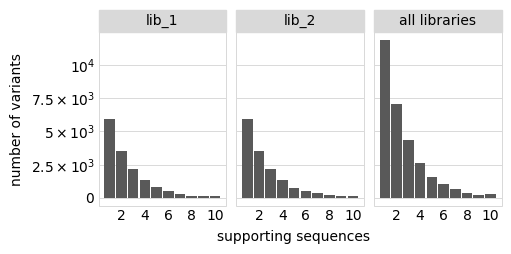

In [15]:
p = variants.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

The set of valid barcodes for each library:

In [16]:
for lib in libs:
    print(f"First few barcodes for library {lib}:")
    print(sorted(variants.valid_barcodes(lib))[ : 3])

First few barcodes for library lib_1:
['AAAAAAAACGTTTTGT', 'AAAAAAAGGCTTATAC', 'AAAAAAATCGTCCGTG']
First few barcodes for library lib_2:
['AAAAAACCCAGACTTA', 'AAAAAACCGGCGGCAG', 'AAAAAATCTACTGCGT']


Plot the number of amino-acid mutations per variant:

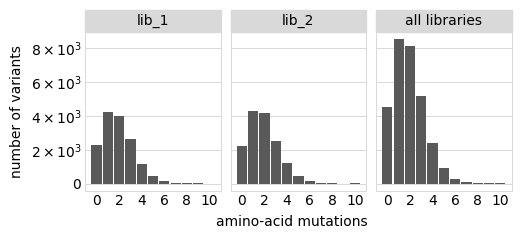

In [17]:
p = variants.plotNumMutsHistogram('aa', samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Number of codon mutations per variant:

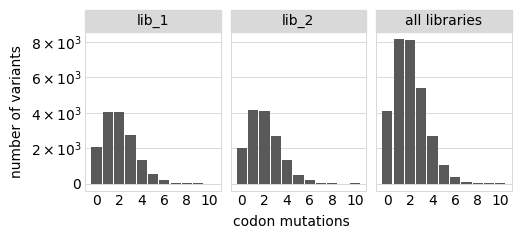

In [18]:
p = variants.plotNumMutsHistogram('codon', samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of codon mutations per variant of each type of mutation.
We make these plots for:
 1. Just single-mutant and wildtype variants
 2. For all variants

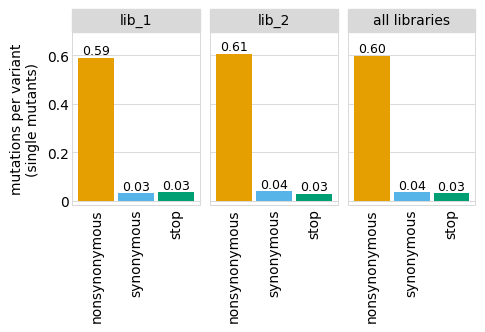

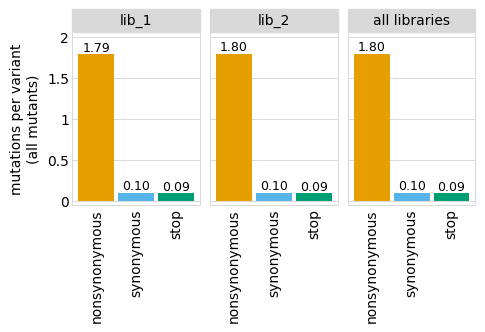

In [19]:
for mut_type in ['single', 'all']:
    p = variants.plotNumCodonMutsByType(mut_type, samples=None)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()

Here are the numerical data in the plots above:

In [20]:
variants.numCodonMutsByType('single', samples=None)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,3615,6112,0.591459
1,lib_1,barcoded variants,synonymous,194,6112,0.031741
2,lib_1,barcoded variants,stop,211,6112,0.034522
3,lib_2,barcoded variants,nonsynonymous,3716,6114,0.607785
4,lib_2,barcoded variants,synonymous,235,6114,0.038436
5,lib_2,barcoded variants,stop,179,6114,0.029277
6,all libraries,barcoded variants,nonsynonymous,7331,12226,0.599624
7,all libraries,barcoded variants,synonymous,429,12226,0.035089
8,all libraries,barcoded variants,stop,390,12226,0.031899


In [21]:
variants.numCodonMutsByType('all', samples=None)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,26916,15000,1.794400
1,lib_1,barcoded variants,synonymous,1510,15000,0.100667
2,lib_1,barcoded variants,stop,1424,15000,0.094933
3,lib_2,barcoded variants,nonsynonymous,26960,15000,1.797333
4,lib_2,barcoded variants,synonymous,1498,15000,0.099867
5,lib_2,barcoded variants,stop,1371,15000,0.091400
6,all libraries,barcoded variants,nonsynonymous,53876,30000,1.795867
7,all libraries,barcoded variants,synonymous,3008,30000,0.100267
8,all libraries,barcoded variants,stop,2795,30000,0.093167


Examine how well amino-acid mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times.
Here we do that for codon and amino-
acid mutations, making separate plots for single mutants and all mutants:

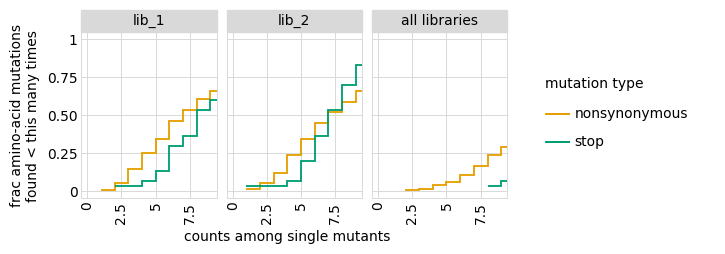

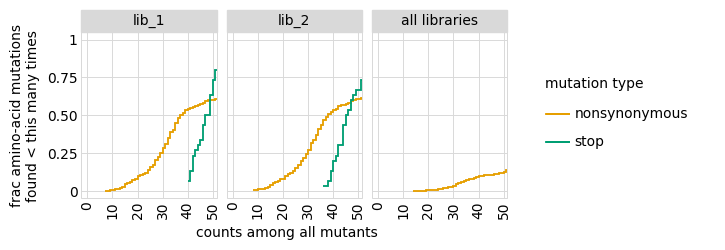

In [22]:
for variant_type in ['single', 'all']:
    p = variants.plotCumulMutCoverage(variant_type,
                                      mut_type='aa',
                                      samples=None)
    _ = p.draw()

We can also get the numerical information plotted above (here for single mutants
only):

In [23]:
variants.mutCounts('single', 'aa', samples=None).head(n=5)

,library,sample,mutation,count,mutation_type,site
0,lib_1,barcoded variants,V16L,25,nonsynonymous,16
1,lib_1,barcoded variants,C19R,21,nonsynonymous,19
2,lib_1,barcoded variants,R12S,21,nonsynonymous,12
3,lib_1,barcoded variants,R26L,21,nonsynonymous,26
4,lib_1,barcoded variants,S11R,21,nonsynonymous,11


Here are the frequencies of mutations along the gene, looking both at single
mutants and all mutants:

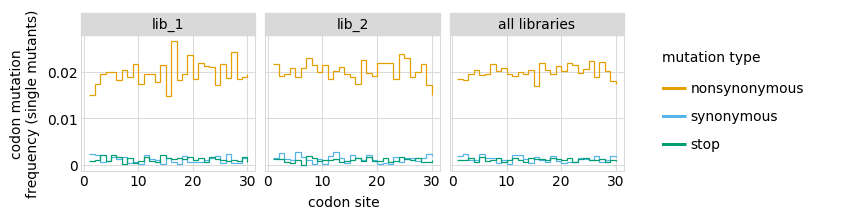

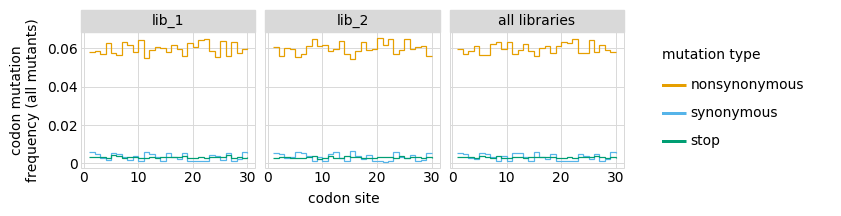

In [24]:
for variant_type in ['single', 'all']:
    p = variants.plotMutFreqs(variant_type,
                              'codon', 
                              samples=None)
    _ = p.draw()

We can also look at mutation frequencies in a heat-map form:

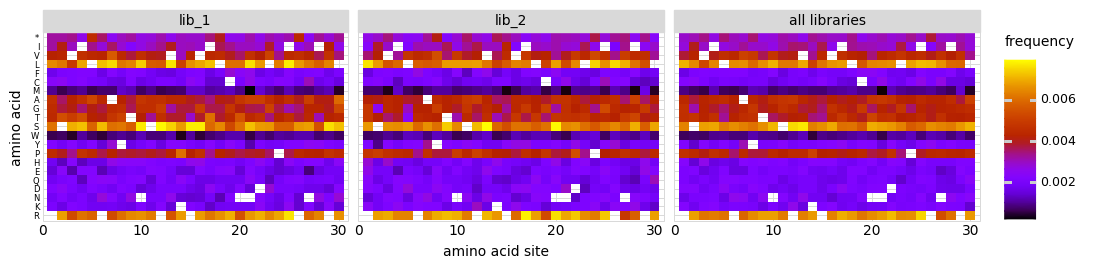

In [25]:
p = variants.plotMutHeatmap('all', 'aa', samples=None)
_ = p.draw()

## Simulate counts for samples
An experiment involves subjecting the library to
different selections and looking at how the frequencies of the variants changes
by using sequencing to count the barcodes in each condition.

Here, we simulate
an experiment by simulating variant counts for samples that have undergone
various selections.

For these simulations, we first need to define a
"phenotype" for each variant.
The phenotype represents how much the frequency of
the variant is expected to increase or decrease after selection.

### Define phenotype function
First, we define a “phenotype” function. We will
do this using a
[SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator),
which follow the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the phenotype in
two steps: an underlying latent phenotype that mutations affect additively, and
then an observed phenotype that is a non-linear
function of the latent phenotype.
The variants are then simulated according to their observed enrichments, which are the exponentials of the observed phenotypes.

First, we initialize the simulator:

In [26]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                                            geneseq,
                                            seed=seed)

Plot the simulated relationship of the latent phenotype with the observed enrichment and phenotype, with a dashed
vertical line indicating the wildtype latent phenotype:

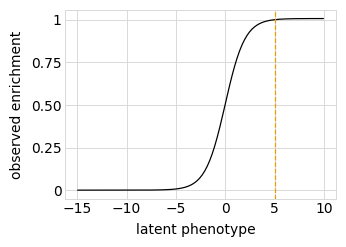

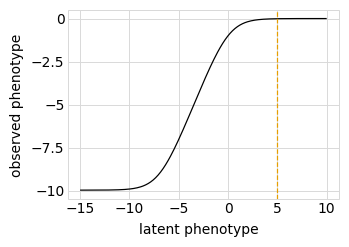

In [27]:
for value in ['enrichment', 'phenotype']:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw()

Plot the latent phenotype, observed phenotype, and observed enrichment of all single amino-acid mutants, with a
dashed vertical line indicating the wildtype:

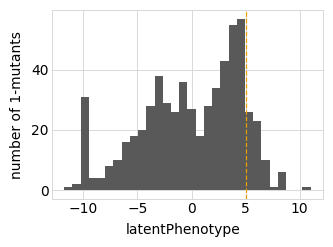

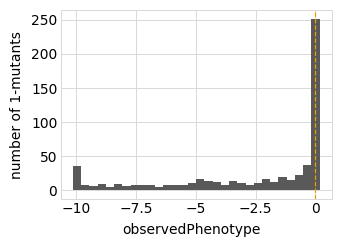

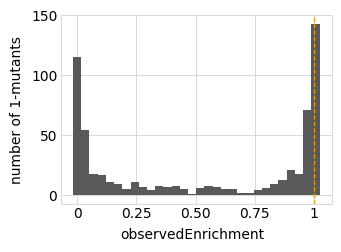

In [28]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw()

### Simulate variant counts
Now we use
[simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts)
to simulate counts of variants when selection on each variant is proportional to
its observed enrichment.
In these simulations, we can fine-tune the simulations
to reflect real experiments, such as by setting the error-rate in variant
calling, bottlenecks when going from the pre- to post-selection samples, and
non-uniformity in library composition.

Here we simulate using several
bottlenecks in the library going from the pre- to post-selection samples, since
in real experiments this seems to be the biggest source of noise / error:

In [29]:
counts = dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={'total_count': variants_per_lib *
                        scipy.random.poisson(avgdepth_per_variant),
                    'uniformity': lib_uniformity},
        pre_sample_name='pre-selection',
        post_samples={name: {'noise': noise,
                             'total_count': variants_per_lib *
                                 scipy.random.poisson(avgdepth_per_variant),
                             'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
        seed=seed,
        )

First few lines of the data frame with the simulated counts:

In [30]:
counts.head(n=5)

,library,barcode,sample,count
0,lib_1,AAAAAAAACGTTTTGT,pre-selection,232
1,lib_1,AAAAAAAGGCTTATAC,pre-selection,182
2,lib_1,AAAAAAATCGTCCGTG,pre-selection,286
3,lib_1,AAAAAAGACAACACCG,pre-selection,78
4,lib_1,AAAAAAGATGTGGTGG,pre-selection,211


### Add counts to variant table
Now add the simulated counts for each library /
sample to the
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [31]:
variants.add_sample_counts_df(counts)

Confirm that we have added the expected number of counts per library /
sample:

In [32]:
variants.n_variants_df()

,library,sample,count
0,lib_1,pre-selection,3030000
1,lib_1,loose_bottle,3195000
2,lib_1,tight_bottle,2985000
3,lib_2,pre-selection,3030000
4,lib_2,loose_bottle,3195000
5,lib_2,tight_bottle,2985000
6,all libraries,pre-selection,6060000
7,all libraries,loose_bottle,6390000
8,all libraries,tight_bottle,5970000


## Analyze sample variant counts
A
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
has methods for summarizing and plotting the variant counts for different
samples.
These methods are mostly the same as we used above to analyze the
variant composition of the libraries themselves, but now we set `samples` to the
samples that we want to analyze (typically `'all'`).
Therefore, rather than each
variant always counting once, each variant is counted in each sample in
proportion to how many counts it has.

In the rawest form, we can directly
access a data frame giving the counts of each variant in each sample:

In [33]:
variants.variant_count_df.head(n=5)

,barcode,count,library,sample,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,CAGTCCGACTGTGCAC,702,lib_1,pre-selection,1,AAC10CGC,N10R,1,1
1,ATATTGAGGCCCGAGT,661,lib_1,pre-selection,1,,,0,0
2,CCCGTTGTTGAAATGG,655,lib_1,pre-selection,1,TCC2GGC,S2G,1,1
3,TGCTATCGCCATACCA,645,lib_1,pre-selection,5,CGT6CCT AAC10GGG ATC17TTC GAC22GGA,R6P N10G I17F D22G,4,4
4,ACGTTTATTCGTCAAG,635,lib_1,pre-selection,2,GCT7AAA AAC10GCC AAC21CGG CCT24ATT,A7K N10A N21R P24I,4,4


First, we get the **average** number of counts per variant:

In [34]:
variants.avgCountsPerVariant()

,library,sample,avg_counts_per_variant
0,lib_1,pre-selection,202
1,lib_1,loose_bottle,213
2,lib_1,tight_bottle,199
3,lib_2,pre-selection,202
4,lib_2,loose_bottle,213
5,lib_2,tight_bottle,199
6,all libraries,pre-selection,202
7,all libraries,loose_bottle,213
8,all libraries,tight_bottle,199


We also plot the average counts per variant:

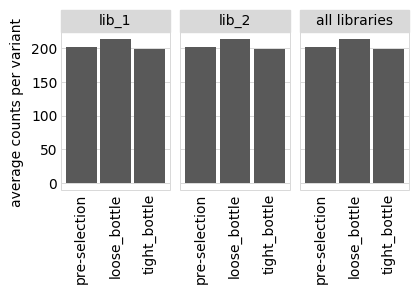

In [35]:
p = variants.plotAvgCountsPerVariant()
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Plot the number of counts for each variant in each sample. 
The horizontal
dashed line shows the total number of variants. 
The plot shows that all
variants are well-sampled in the pre-selection libraries, but that post-
selection some variants are sampled more or less.
This is expected since
selection will decrease and increase the frequency of variants:

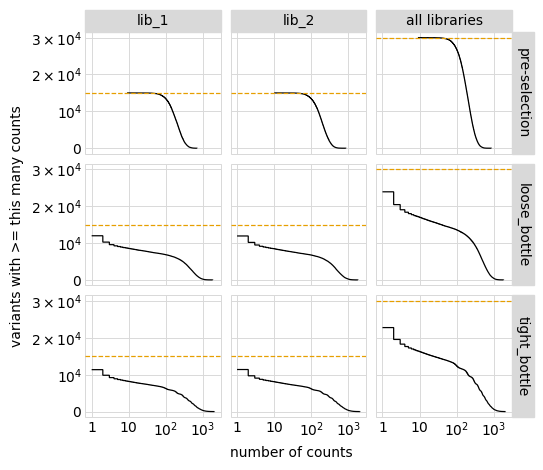

In [36]:
p = variants.plotCumulVariantCounts()
_ = p.draw()

Distribution of the number of amino-acid mutations per variant in each sample.
As expected, mutations go down after selection:

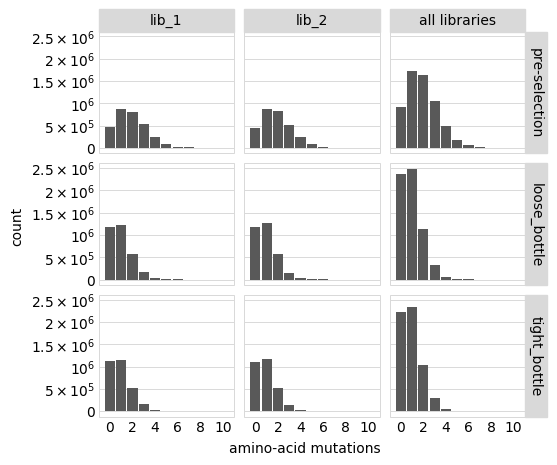

In [37]:
p = variants.plotNumMutsHistogram(mut_type='aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of mutations of each type per variant among just single mutants
(and wildtype) and among all variants:

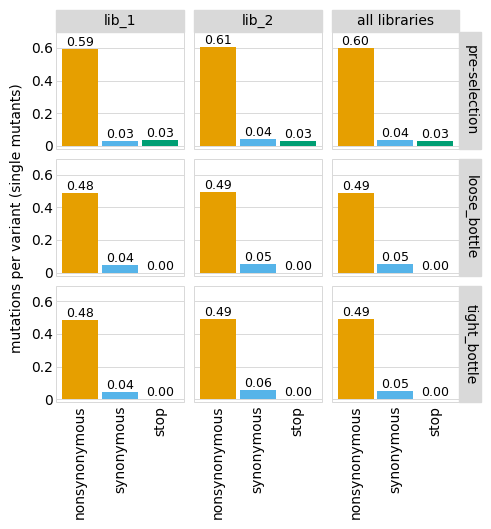

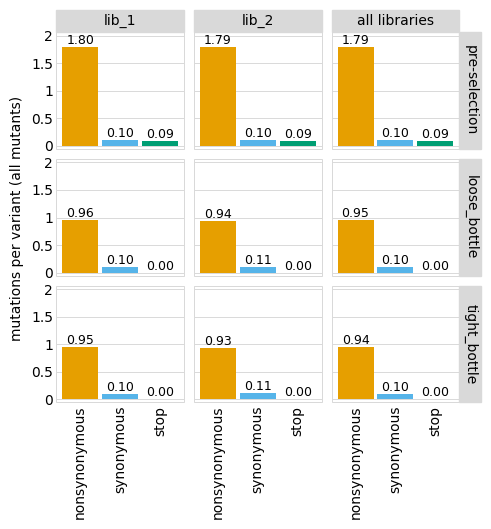

In [38]:
for variant_type in ['single', 'all']:
    p = variants.plotNumCodonMutsByType(variant_type)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()

Here are the numerical data plotted above (just for the individual libraries and all mutations):

In [39]:
variants.numCodonMutsByType(variant_type='all', libraries=libs)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,5441807,3030000,1.795976
1,lib_1,pre-selection,synonymous,302083,3030000,0.099697
2,lib_1,pre-selection,stop,285329,3030000,0.094168
3,lib_1,loose_bottle,nonsynonymous,3063613,3195000,0.958877
4,lib_1,loose_bottle,synonymous,317148,3195000,0.099264
5,lib_1,loose_bottle,stop,1698,3195000,0.000531
6,lib_1,tight_bottle,nonsynonymous,2834185,2985000,0.949476
7,lib_1,tight_bottle,synonymous,291208,2985000,0.097557
8,lib_1,tight_bottle,stop,1357,2985000,0.000455
9,lib_2,pre-selection,nonsynonymous,5431534,3030000,1.792585


Here are mutation frequencies as a function of primary sequence among all variants:

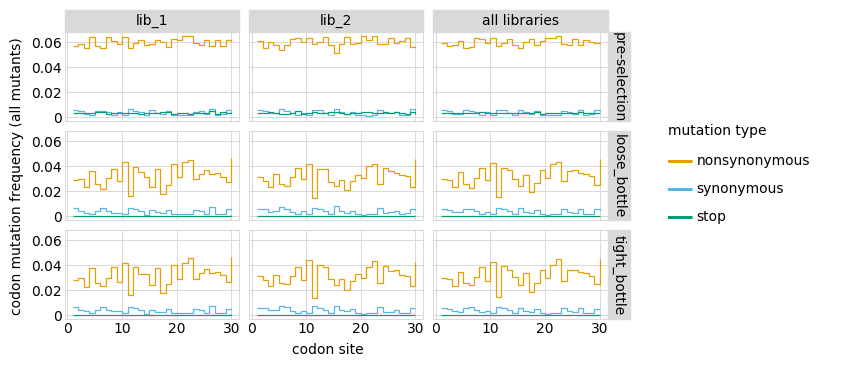

In [40]:
p = variants.plotMutFreqs(variant_type='all',
                          mut_type='codon')
_ = p.draw()

Plot how thoroughly amino-acid mutations are sampled, doing this separately among all variants and single-mutant variants.
The plots below show that the stop mutations are sampled very poorly post-selection because they are eliminated during selection:

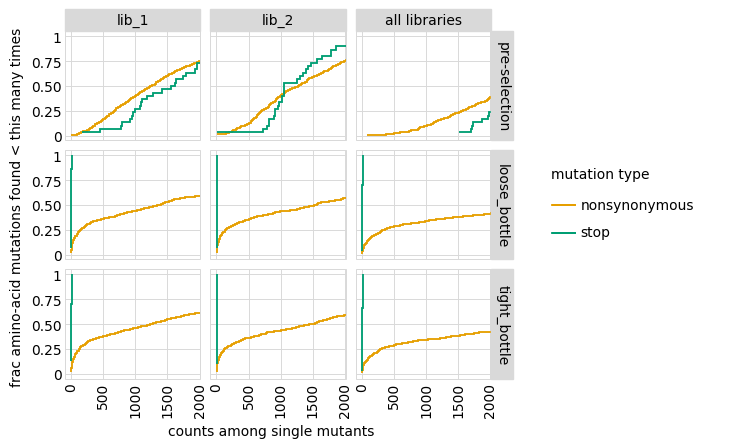

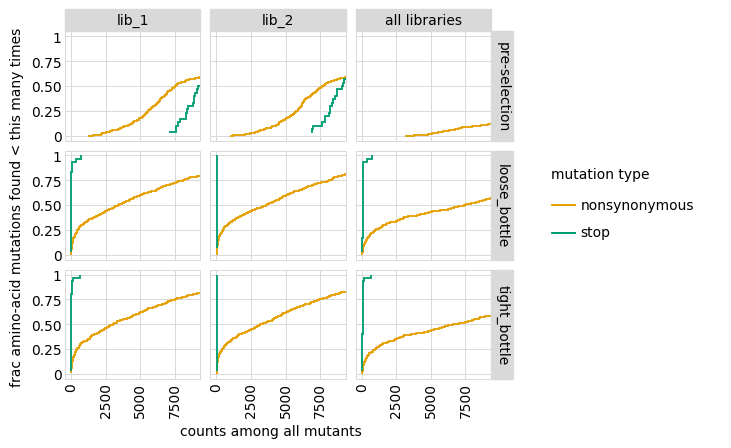

In [41]:
for variant_type in ['single', 'all']:
    p = variants.plotCumulMutCoverage(variant_type=variant_type,
                                      mut_type='aa')
    _ = p.draw()

## Functional scores for variants
The
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
method calculates a functional score for each variant based on its change in
frequency from pre- to post-selection.

To calculate these scores, we
need to pair each
post-selection sample with a pre-selection one.
In this case,
the pre-selection sample is named 'pre-selection' for all post-selection
samples:

In [42]:
func_scores = variants.func_scores('pre-selection',
                                   libraries=libs)

The resulting data frame has a functional score (and its
variance) for each barcoded variant:

In [43]:
func_scores.head(n=5)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
0,lib_1,pre-selection,loose_bottle,CAGTCCGACTGTGCAC,-7.287026,0.183958,702,11,420870,1076002,0.5,AAC10CGC,1,N10R,1
1,lib_1,pre-selection,loose_bottle,ATATTGAGGCCCGAGT,0.129869,0.004278,661,1850,420870,1076002,0.5,,0,,0
2,lib_1,pre-selection,loose_bottle,CCCGTTGTTGAAATGG,-6.038260,0.084804,655,25,420870,1076002,0.5,TCC2GGC,1,S2G,1
3,lib_1,pre-selection,loose_bottle,TGCTATCGCCATACCA,-8.881151,0.597908,645,3,420870,1076002,0.5,CGT6CCT AAC10GGG ATC17TTC GAC22GGA,4,R6P N10G I17F D22G,4
4,lib_1,pre-selection,loose_bottle,ACGTTTATTCGTCAAG,-1.984743,0.008352,635,410,420870,1076002,0.5,GCT7AAA AAC10GCC AAC21CGG CCT24ATT,4,A7K N10A N21R P24I,4


In [44]:
func_scores.tail(n=5)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
59995,lib_2,pre-selection,tight_bottle,GGAGCTCAATCGAGTC,-6.770493,4.255251,22,0,404449,981235,0.5,CGT15GGG,1,R15G,1
59996,lib_2,pre-selection,tight_bottle,GTGCGCCAGAACACAT,-6.636192,4.264275,20,0,404449,981235,0.5,TCC2ATT TAC8CAT GAC22AAG,3,S2I Y8H D22K,3
59997,lib_2,pre-selection,tight_bottle,GCGCAGATCGTCATGA,-6.564042,4.269482,19,0,404449,981235,0.5,TGC19AGA,1,C19R,1
59998,lib_2,pre-selection,tight_bottle,ATGCACAGCGAAGGTC,-6.136621,4.306288,14,0,404449,981235,0.5,TCC2AGC CGT15GGT CTG30ACA,3,R15G L30T,2
59999,lib_2,pre-selection,tight_bottle,GAATGCTTTTCGTCAC,-5.670957,4.360971,10,0,404449,981235,0.5,CGC26TAA,1,R26*,1


We can also calculate functional scores at the level of amino-acid or codon
substitutions rather than at the level of variants. 
This calculation groups all
variants with the same substitutions before calculating the functional score.
Here are scores grouping by amino-acid substitutions; we also set
`syn_as_wt=True` to include variants with only synonymous mutations in the
counts of wild type in this case:

In [45]:
aa_func_scores = variants.func_scores('pre-selection',
                                      by='aa_substitutions',
                                      syn_as_wt=True,
                                      libraries=libs)
aa_func_scores.head(n=5)

,library,pre_sample,post_sample,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions
0,lib_1,pre-selection,loose_bottle,N10R,-7.676153,0.056204,2998,37,462218,1182297,0.5,1
1,lib_1,pre-selection,loose_bottle,,0.000000,0.000013,462218,1182297,462218,1182297,0.5,0
2,lib_1,pre-selection,loose_bottle,S2G,-5.958000,0.024772,2126,87,462218,1182297,0.5,1
3,lib_1,pre-selection,loose_bottle,R6P N10G I17F D22G,-8.881865,0.597908,645,3,462218,1182297,0.5,4
4,lib_1,pre-selection,loose_bottle,A7K N10A N21R P24I,-1.985456,0.008352,635,410,462218,1182297,0.5,4


We can plot the distribution of the functional scores for variants.
These plots
are most informative if we classify variants
by the “types” of mutations they
have, which we do here using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants)
method, which adds a  column called `variant_class` to the data frame:

In [46]:
func_scores = dms_variants.codonvarianttable.CodonVariantTable.classifyVariants(func_scores)

(func_scores
 .head(n=5)
 [['codon_substitutions','aa_substitutions', 'variant_class']]
 )

,codon_substitutions,aa_substitutions,variant_class
0,AAC10CGC,N10R,1 nonsynonymous
1,,,wildtype
2,TCC2GGC,S2G,1 nonsynonymous
3,CGT6CCT AAC10GGG ATC17TTC GAC22GGA,R6P N10G I17F D22G,>1 nonsynonymous
4,GCT7AAA AAC10GCC AAC21CGG CCT24ATT,A7K N10A N21R P24I,>1 nonsynonymous


Now we use [plotnine](https://plotnine.readthedocs.io) to plot the distributions
of scores in ggplot2-like syntax, coloring by the variant class.
This plot shows
the expected behavior for different variant classes; for instance, stop codon
variants tend to have low scores and synonymous variants tend to have wildtype-like (near 0) scores.
As expected, there is more noise with a tighter bottleneck:

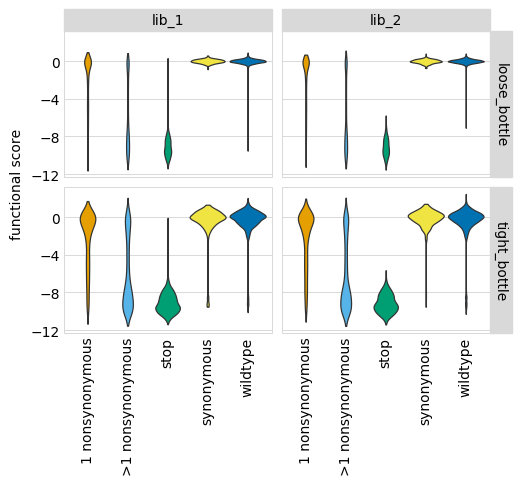

In [47]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs), 
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Fit global epistasis models
We now fit global epistasis models to the functional scores from each simulated experiment.
For background on these models, see [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550).
The models we fits are implemented in [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html), which has extensive documentation.

The primary model of interest is [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis), which assumes that the observed phenotype is a monotonic non-linear function of an underlying additive latent phenotype.
As a control, we also fit a [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, which assumes that mutations simply contribute additively to the observed phenotype:

For the fitting, we first convert the set of functional scores into a binary representation using a [BinaryMap]((https://jbloomlab.github.io/dms_variants/dms_variants.binarymap.html#dms_variants.binarymap.BinaryMap)).
Then we create the model, fit it, and store it:

In [48]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(modeltype, sample, lib)`

for (sample, lib), scores in func_scores.groupby(['post_sample',
                                                  'library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for modeltype, EpistasisModel in [
            ('global epistasis', dms_variants.globalepistasis.MonotonicSplineEpistasis),
            ('no epistasis', dms_variants.globalepistasis.NoEpistasis),
            ]:
        print(f"Fitting {modeltype} model to {sample}, {lib}...", end=' ')
    
        start = time.time()
        model = EpistasisModel(bmap)
        model.fit()
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(modeltype, sample, lib)] = model

Fitting global epistasis model to loose_bottle, lib_1... fitting took 3.9 sec.
Fitting no epistasis model to loose_bottle, lib_1... fitting took 0.2 sec.
Fitting global epistasis model to loose_bottle, lib_2... fitting took 17.5 sec.
Fitting no epistasis model to loose_bottle, lib_2... fitting took 0.2 sec.
Fitting global epistasis model to tight_bottle, lib_1... fitting took 7.1 sec.
Fitting no epistasis model to tight_bottle, lib_1... fitting took 0.2 sec.
Fitting global epistasis model to tight_bottle, lib_2... fitting took 9.0 sec.
Fitting no epistasis model to tight_bottle, lib_2... fitting took 0.2 sec.


Now we want to see which model fits the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better, and below we see that the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model always fits the data much better:

In [49]:
logliks_df = (
    pd.DataFrame.from_records(
            [(modeltype, sample, lib, model.nparams, model.loglik) for
             (modeltype, sample, lib), model in models.items()],
            columns=['model', 'sample', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['sample', 'library'])
    )

logliks_df.round(1)

model  n_parameters  log_likelihood      AIC
sample       library                                                         
loose_bottle lib_1    global epistasis           608        -13707.9  28631.7
             lib_1        no epistasis           602        -28884.0  58972.0
             lib_2    global epistasis           608        -11477.9  24171.9
             lib_2        no epistasis           602        -29255.0  59714.1
tight_bottle lib_1    global epistasis           608        -22445.3  46106.5
             lib_1        no epistasis           602        -31187.9  63579.8
             lib_2    global epistasis           608        -22307.5  45831.0
             lib_2        no epistasis           602        -31409.3  64022.6

Because the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model fits so much better than the additive [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, below we are just going to analyze the results from the global epistasis model.

First, we will examine how the model looks on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.
We also compute the measured and model-predicted enrichments for each variant (recall that the functional score / observed phenotype is the $\log_2$ of the enrichment as described [here](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)):

In [50]:
variants_df = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 library=lib,
                 predicted_enrichment=lambda x: model.enrichments(
                                                 x['observed_phenotype']),
                 measured_enrichment=lambda x: 2**x['func_score'],
                 )
         for (modeltype, sample, lib), model in models.items()
         if modeltype == 'global epistasis'],
        ignore_index=True, sort=False)

variants_df.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,sample,library,predicted_enrichment,measured_enrichment
0,N10R,-7.29,0.18,-2.25,-7.18,loose_bottle,lib_1,0.01,0.01
1,,0.13,0.00,0.00,-0.04,loose_bottle,lib_1,1.00,1.09
2,S2G,-6.04,0.08,-1.87,-5.93,loose_bottle,lib_1,0.02,0.02
3,R6P N10G I17F D22G,-8.88,0.60,-4.87,-9.48,loose_bottle,lib_1,0.00,0.00
4,A7K N10A N21R P24I,-1.98,0.01,-1.14,-1.97,loose_bottle,lib_1,0.26,0.25


Below we plot the relationships among the latent phenotype from the model, the observed phenotype from the model, and the measured functional score for all variants used to fit the model:

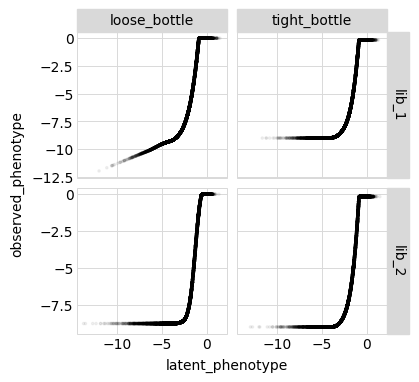

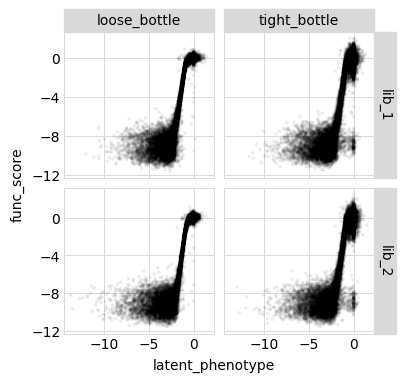

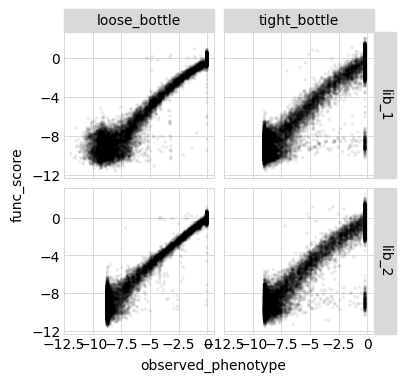

In [51]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ sample', scales='free_y') +
        theme(figure_size=(2 * variants_df['sample'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
    _ = p.draw()

## Model vs measurements vs truth for all variants

Because we simulated the variants, we can also use the [SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator) used in these simulations to get the **true** phenotype of each variant.
(Obviously in real non-simulated experiments the true phenotypes are unknown.)
We get the true latent phenotype, the true observed phenotype (which corresponds to the functional score), and true enrichment:

In [52]:
variants_df = (
    variants_df
    .assign(
        true_latent_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.latentPhenotype),
        true_enrichment=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedEnrichment),
        true_observed_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedPhenotype),
        )
    )

variants_df.head().round(2)

,aa_substitutions,func_score,func_score_var,latent_phenotype,observed_phenotype,sample,library,predicted_enrichment,measured_enrichment,true_latent_phenotype,true_enrichment,true_observed_phenotype
0,N10R,-7.29,0.18,-2.25,-7.18,loose_bottle,lib_1,0.01,0.01,-5.48,0.01,-7.60
1,,0.13,0.00,0.00,-0.04,loose_bottle,lib_1,1.00,1.09,5.00,1.00,0.00
2,S2G,-6.04,0.08,-1.87,-5.93,loose_bottle,lib_1,0.02,0.02,-4.13,0.02,-5.89
3,R6P N10G I17F D22G,-8.88,0.60,-4.87,-9.48,loose_bottle,lib_1,0.00,0.00,-24.66,0.00,-9.97
4,A7K N10A N21R P24I,-1.98,0.01,-1.14,-1.97,loose_bottle,lib_1,0.26,0.25,-1.02,0.27,-1.90


Now we calculate the correlations between the true enrichment (from the simulation) and the measured enrichment or model-predicted enrichment, calculating the correlations across all variants.
We do this using enrichment rather than observed phenotype as we expect the observed phenotypes to be very noisy at the "low end" (since experiments lose the sensitivity to distinguish among bad and really-bad variants):

In [53]:
enrichments_corr = (
    variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'library', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'library', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'library'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

enrichment_type       measurement  model prediction
sample       library                               
loose_bottle lib_1           0.98              0.99
             lib_2           0.98              1.00
tight_bottle lib_1           0.82              0.99
             lib_2           0.82              0.99

And below are the correlation plots corresponding to the correlation coefficients tabulated above:

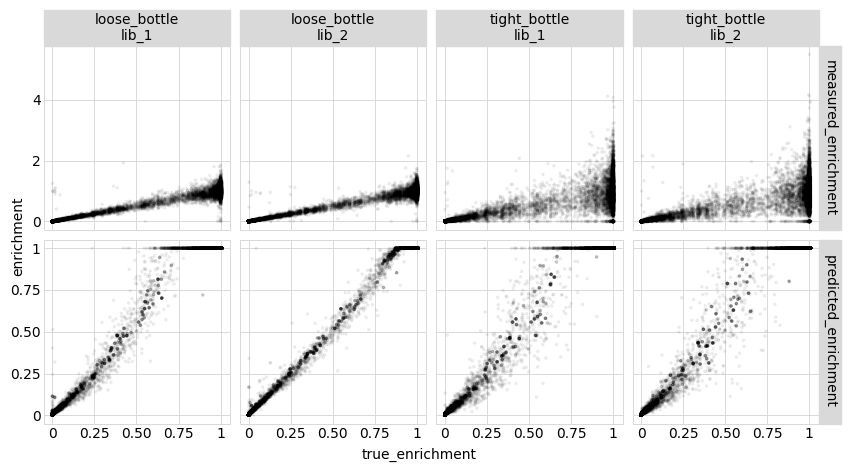

In [54]:
p = (ggplot(variants_df
            .melt(id_vars=['sample', 'library', 'true_enrichment'],
                  value_vars=['predicted_enrichment', 'measured_enrichment'],
                  var_name='enrichment_type',
                  value_name='enrichment',
                  ),
            aes('true_enrichment', 'enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('enrichment_type ~ sample + library',
                scales='free_y') +
     theme(figure_size=(2.5 * (variants_df['sample'].nunique() +
                               variants_df['library'].nunique()),
                        5)
           )
     )

_ = p.draw()

These results show that the model predictions are closer to the true values than the actual measurements, which is great!
This could be because modeling the data helps extract more signal from multiple mutants--but it could also be for the trivial reason that the model effectively averages over multiple variants with the same mutations, which could be more accurate than the individual measurements.
Therefore, in the next section we look at this issue...

## Model vs measurements vs truth for amino-acid variants
We want to see if the model still outperforms the experiments if look at the level of **amino-acid** variants (meaning we pool the counts for all variants with the same amino-acid substitutions together before calculating the functional scores).
Recall that above we already got such functional scores into the variable `aa_func_scores`:

First we get a data frame of simulated functional scores calculated at the level of amino-acid variants (pooling all barcoded variants with the same amino-acid mutations):

In [55]:
aa_variants_df = (
    aa_func_scores
    .rename(columns={'post_sample': 'sample'})
    [['sample', 'library', 'aa_substitutions',
      'n_aa_substitutions', 'func_score']]
    .assign(measured_enrichment=lambda x: 2**x['func_score'])
    )

aa_variants_df.head().round(2)

,sample,library,aa_substitutions,n_aa_substitutions,func_score,measured_enrichment
0,loose_bottle,lib_1,N10R,1,-7.68,0.00
1,loose_bottle,lib_1,,0,0.00,1.00
2,loose_bottle,lib_1,S2G,1,-5.96,0.02
3,loose_bottle,lib_1,R6P N10G I17F D22G,4,-8.88,0.00
4,loose_bottle,lib_1,A7K N10A N21R P24I,4,-1.99,0.25


Now we add the model-predicted latent phenotype, observed phenotype, and enrichment for each amino-acid variant using the [AbstractEpistasis.add_phenotypes_to_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.add_phenotypes_to_df) method:

In [56]:
df_list = []
for (sample, lib), df in aa_variants_df.groupby(['sample', 'library']):
    model = models[('global epistasis', sample, lib)]
    df_list.append(model.add_phenotypes_to_df(df)
                   .assign(predicted_enrichment=lambda x: 
                              model.enrichments(x['observed_phenotype'])
                           )
                   )
aa_variants_df = pd.concat(df_list, ignore_index=True, sort=False)

aa_variants_df.head().round(2)

,sample,library,aa_substitutions,n_aa_substitutions,func_score,measured_enrichment,latent_phenotype,observed_phenotype,predicted_enrichment
0,loose_bottle,lib_1,N10R,1,-7.68,0.00,-2.25,-7.18,0.01
1,loose_bottle,lib_1,,0,0.00,1.00,0.00,-0.04,1.00
2,loose_bottle,lib_1,S2G,1,-5.96,0.02,-1.87,-5.93,0.02
3,loose_bottle,lib_1,R6P N10G I17F D22G,4,-8.88,0.00,-4.87,-9.48,0.00
4,loose_bottle,lib_1,A7K N10A N21R P24I,4,-1.99,0.25,-1.14,-1.97,0.26


Now we add the "true" values from the simulator:

In [57]:
aa_variants_df = (
    aa_variants_df
    .assign(
        true_latent_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.latentPhenotype),
        true_enrichment=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedEnrichment),
        true_observed_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedPhenotype),
        )
    )

aa_variants_df.head().round(2)

,sample,library,aa_substitutions,n_aa_substitutions,func_score,measured_enrichment,latent_phenotype,observed_phenotype,predicted_enrichment,true_latent_phenotype,true_enrichment,true_observed_phenotype
0,loose_bottle,lib_1,N10R,1,-7.68,0.00,-2.25,-7.18,0.01,-5.48,0.01,-7.60
1,loose_bottle,lib_1,,0,0.00,1.00,0.00,-0.04,1.00,5.00,1.00,0.00
2,loose_bottle,lib_1,S2G,1,-5.96,0.02,-1.87,-5.93,0.02,-4.13,0.02,-5.89
3,loose_bottle,lib_1,R6P N10G I17F D22G,4,-8.88,0.00,-4.87,-9.48,0.00,-24.66,0.00,-9.97
4,loose_bottle,lib_1,A7K N10A N21R P24I,4,-1.99,0.25,-1.14,-1.97,0.26,-1.02,0.27,-1.90


Now we calculate and plot the correlations between the true enrichments from the simulations and the measured values and the ones predicted by the model:

In [58]:
enrichments_corr = (
    aa_variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'library', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'library', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'library'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

enrichment_type       measurement  model prediction
sample       library                               
loose_bottle lib_1           0.98              0.99
             lib_2           0.99              1.00
tight_bottle lib_1           0.87              0.99
             lib_2           0.87              0.99

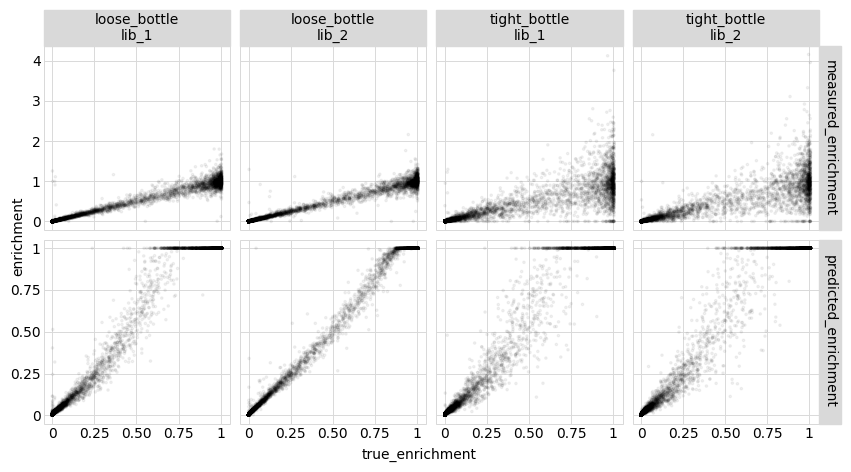

In [59]:
p = (ggplot(aa_variants_df
            .melt(id_vars=['sample', 'library', 'true_enrichment'],
                  value_vars=['predicted_enrichment', 'measured_enrichment'],
                  var_name='enrichment_type',
                  value_name='enrichment',
                  ),
            aes('true_enrichment', 'enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('enrichment_type ~ sample + library',
                scales='free_y') +
     theme(figure_size=(2.5 * (variants_df['sample'].nunique() +
                               variants_df['library'].nunique()),
                        5)
           )
     )

_ = p.draw()

The results above show that the model still outperforms the direct measurements even when the measurements are aggregated at the level of amino-acid variants.

## Model vs measurements vs truth for single mutants
Now we repeat the above analysis for just **single** amino-acid mutants.

First, get the single amino-acid mutant variants:

In [60]:
single_aa_variants_df = (
    aa_variants_df
    .query('n_aa_substitutions == 1')
    .reset_index(drop=True)
    )

single_aa_variants_df.head()

,sample,library,aa_substitutions,n_aa_substitutions,func_score,measured_enrichment,latent_phenotype,observed_phenotype,predicted_enrichment,true_latent_phenotype,true_enrichment,true_observed_phenotype
0,loose_bottle,lib_1,N10R,1,-7.676153,0.004889,-2.249843,-7.177078,0.007117,-5.483343,0.005162,-7.597873
1,loose_bottle,lib_1,S2G,1,-5.958000,0.016087,-1.866617,-5.926983,0.016928,-4.134948,0.016842,-5.891819
2,loose_bottle,lib_1,L23S,1,-0.008964,0.993806,-0.330899,-0.042523,1.000000,3.410787,0.974588,-0.037136
3,loose_bottle,lib_1,S11T,1,-10.435193,0.000722,-2.635871,-8.026721,0.003949,-8.894418,0.001138,-9.779386
4,loose_bottle,lib_1,R29Y,1,-0.209599,0.864777,-0.630496,-0.042523,1.000000,1.772080,0.860615,-0.216561


Now tabulate and plot how the model predictions and measurements compare to the true values:

In [61]:
enrichments_corr = (
    single_aa_variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'library', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'library', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'library'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

enrichment_type       measurement  model prediction
sample       library                               
loose_bottle lib_1           0.99              0.99
             lib_2           0.99              1.00
tight_bottle lib_1           0.95              0.99
             lib_2           0.95              0.99

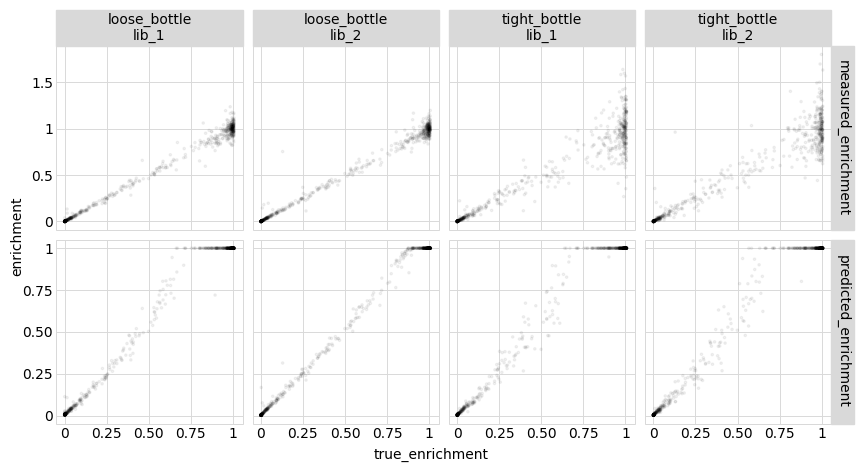

In [62]:
p = (ggplot(single_aa_variants_df
            .melt(id_vars=['sample', 'library', 'true_enrichment'],
                  value_vars=['predicted_enrichment', 'measured_enrichment'],
                  var_name='enrichment_type',
                  value_name='enrichment',
                  ),
            aes('true_enrichment', 'enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('enrichment_type ~ sample + library',
                scales='free_y') +
     theme(figure_size=(2.5 * (variants_df['sample'].nunique() +
                               variants_df['library'].nunique()),
                        5)
           )
     )

_ = p.draw()

We see that even for single mutants, fitting the global epistasis model leads to more accurate measurements of the effects of mutations.
Presumably this is because these models are able to effectively extract information from the multiple mutants.